<a href="https://colab.research.google.com/github/ullasbc02/obesity-risk-analytics/blob/main/03_unsupervised_learning_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import (
    KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
)
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [12]:
# Load dataset
DATASET = "/content/drive/MyDrive/obesity-risk-analytics/data/processed_final/"
df_final = pd.read_csv(os.path.join(DATASET, "df_final_demographic.csv"))

df_final = pd.read_csv(
    os.path.join(DATASET, "df_final_demographic.csv"),
    dtype={"GEOID": str}
)

df_final["GEOID"] = df_final["GEOID"].str.zfill(5)


print("Dataset shape:", df_final.shape)
df_final.head()

Dataset shape: (3121, 100)


,obesity_rate,poverty_rate,physical_inactivity_rate,low_access_food_rate,median_household_income,unemployment_rate,shortage_status,shortage_code,SUMLEV,STATE,...,county_code,pct_white,pct_black,pct_native,pct_asian,pct_pacific,pct_two_plus,pct_hispanic,pct_non_hispanic,dominant_group
0,0.222000,0.090,0.189000,0.486825,96966.0,0.035162,At least part of county is shortage area,1,NaN,NaN,...,1,0.845836,0.033922,0.008037,0.007092,0.00067,0.017375,0.045702,0.910133,pct_white
1,0.293000,0.108,0.209000,0.497841,75336.0,0.037397,At least part of county is shortage area,1,NaN,NaN,...,3,0.845836,0.033922,0.008037,0.007092,0.00067,0.017375,0.045702,0.910133,pct_white
2,0.274000,0.070,0.198000,0.600196,81721.0,0.030787,At least part of county is shortage area,1,NaN,NaN,...,7,0.845836,0.033922,0.008037,0.007092,0.00067,0.017375,0.045702,0.910133,pct_white
3,0.310000,0.120,0.223000,0.572042,69687.0,0.037745,At least part of county is shortage area,1,NaN,NaN,...,9,0.845836,0.033922,0.008037,0.007092,0.00067,0.017375,0.045702,0.910133,pct_white
4,0.307001,0.078,0.218001,0.578048,75226.0,0.034857,At least part of county is shortage area,1,NaN,NaN,...,11,0.845836,0.033922,0.008037,0.007092,0.00067,0.017375,0.045702,0.910133,pct_white


In [13]:
ses_features = [
    "poverty_rate",
    "median_household_income",
    "physical_inactivity_rate",
    "low_access_food_rate",
    "unemployment_rate",
]

demo_features = [
    "pct_white",
    "pct_black",
    "pct_hispanic",
    "pct_asian",
    "pct_native"
]

all_features = ses_features + demo_features
target_col = "obesity_rate"

In [14]:
economic_features = [
    "poverty_rate",
    "median_household_income",
    "unemployment_rate",
]

health_features = [
    "physical_inactivity_rate",
    "low_access_food_rate",
]

In [15]:
def calculate_feature_weights(df, features, target_col_name):
    X = df[features].values
    y = df[target_col_name].values

    rf = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X, y)

    importances = rf.feature_importances_
    weights = importances / importances.mean()

    print("Feature Importances:")
    display(pd.Series(importances, index=features).sort_values(ascending=False))

    print("Weights used for clustering:")
    display(pd.Series(weights, index=features).sort_values(ascending=False))

    return weights

# Compute weights for ALL features
weights_all = calculate_feature_weights(df_final, all_features, target_col)

Feature Importances:


,0
physical_inactivity_rate,0.399276
median_household_income,0.103002
low_access_food_rate,0.081343
pct_asian,0.078204
pct_hispanic,0.064438
unemployment_rate,0.060102
pct_native,0.057601
pct_black,0.053253
poverty_rate,0.051714
pct_white,0.051067


Weights used for clustering:


,0
physical_inactivity_rate,3.992759
median_household_income,1.030022
low_access_food_rate,0.813429
pct_asian,0.782039
pct_hispanic,0.644381
unemployment_rate,0.601022
pct_native,0.576015
pct_black,0.532526
poverty_rate,0.517136
pct_white,0.510672


In [16]:
X = df_final[all_features].copy()
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X)

# scaler = StandardScaler()
# X_scaled_all = scaler.fit_transform(df_final[all_features])

# Multiply each feature by its weight
# X_weighted_all = X_scaled_all * weights_all
# print("Weighted feature matrix shape:", X_weighted_all.shape)

X_weighted_all = X_scaled_all

In [17]:
def evaluate_clustering(X, labels, method_name, param_desc):

    unique_labels = np.unique(labels)
    has_noise = -1 in unique_labels
    n_clusters = len(unique_labels) - (1 if has_noise else 0)

    if n_clusters < 2:
        return {
            "method": method_name,
            "param": param_desc,
            "silhouette": np.nan,
            "calinski": np.nan,
            "davies": np.nan,
            "n_clusters": n_clusters,
            "noise_frac": np.mean(labels == -1) if has_noise else 0,
        }

    mask = labels != -1
    X_valid = X[mask]
    labels_valid = labels[mask]

    sil = silhouette_score(X_valid, labels_valid)
    ch  = calinski_harabasz_score(X_valid, labels_valid)
    db  = davies_bouldin_score(X_valid, labels_valid)

    return {
        "method": method_name,
        "param": param_desc,
        "silhouette": sil,
        "calinski": ch,
        "davies": db,
        "n_clusters": n_clusters,
        "noise_frac": np.mean(labels == -1) if has_noise else 0,
    }

In [ ]:
def run_and_evaluate_clustering_extended(X_data, evaluate_func):
    results = []
    labels_store = {}


    # 1. KMEANS EXTENDED

    for k in range(2, 10):  # extended from 6 → 10
        for init in ["k-means++", "random"]:
            for max_iter in [300, 500]:
                km = KMeans(
                    n_clusters=k,
                    init=init,
                    max_iter=max_iter,
                    random_state=42,
                    n_init=10
                )
                lab = km.fit_predict(X_data)
                param = f"K={k},init={init},iter={max_iter}"
                res = evaluate_func(X_data, lab, "KMeans", param)
                results.append(res)
                labels_store[("KMeans", param)] = lab


    # 2. AGGLOMERATIVE EXTENDED

    for k in range(2, 10):
        for link in ["ward", "average", "complete"]:
            # ward only works with euclidean
            if link == "ward":
                ag = AgglomerativeClustering(n_clusters=k, linkage="ward")
                lab = ag.fit_predict(X_data)
                param = f"K={k},link={link}"
                res = evaluate_func(X_data, lab, "Agglomerative", param)
                results.append(res)
                labels_store[("Agglomerative", param)] = lab
            else:
                for affinity in ["euclidean", "manhattan"]:
                    ag = AgglomerativeClustering(
                        n_clusters=k,
                        linkage=link,
                        metric=affinity
                    )
                    lab = ag.fit_predict(X_data)
                    param = f"K={k},link={link},aff={affinity}"
                    res = evaluate_func(X_data, lab, "Agglomerative", param)
                    results.append(res)
                    labels_store[("Agglomerative", param)] = lab


    # 3. GMM EXTENDED

    for k in range(2, 10):
        for cov in ["full", "diag", "tied", "spherical"]:
            gmm = GaussianMixture(
                n_components=k,
                covariance_type=cov,
                random_state=42
            )
            lab = gmm.fit_predict(X_data)
            param = f"K={k},cov={cov}"
            res = evaluate_func(X_data, lab, "GMM", param)
            results.append(res)
            labels_store[("GMM", param)] = lab


    # 4. SPECTRAL EXTENDED

    for k in range(2, 10):
        for neighbors in [5, 10, 20]:
            spec = SpectralClustering(
                n_clusters=k,
                n_neighbors=neighbors,
                affinity="nearest_neighbors",
                assign_labels="kmeans",
                random_state=42,
                n_init=10
            )
            lab = spec.fit_predict(X_data)
            param = f"K={k},nn={neighbors}"
            res = evaluate_func(X_data, lab, "Spectral", param)
            results.append(res)
            labels_store[("Spectral", param)] = lab


    # 5. DBSCAN EXTENDED

    for eps in [0.4, 0.5, 0.7, 0.9, 1.1]:
        for ms in [3, 5, 10]:
            for metric in ["euclidean", "manhattan"]:
                db = DBSCAN(
                    eps=eps,
                    min_samples=ms,
                    metric=metric
                )
                lab = db.fit_predict(X_data)
                param = f"eps={eps},ms={ms},met={metric}"
                res = evaluate_func(X_data, lab, "DBSCAN", param)
                results.append(res)
                labels_store[("DBSCAN", param)] = lab


    # 6. HDBSCAN EXTENDED

    for mcs in [10, 20, 40, 60]:
        for ms in [5, 10, 20]:
            hdb = hdbscan.HDBSCAN(
                min_cluster_size=mcs,
                min_samples=ms,
                cluster_selection_method="eom"
            )
            lab = hdb.fit_predict(X_data)
            param = f"mcs={mcs},ms={ms}"
            res = evaluate_func(X_data, lab, "HDBSCAN", param)
            results.append(res)
            labels_store[("HDBSCAN", param)] = lab

    results_df = pd.DataFrame(results).sort_values("silhouette", ascending=False)
    return results_df, labels_store


results_df_all, labels_store_all = run_and_evaluate_clustering_extended(
    X_weighted_all, evaluate_clustering
)

results_df_all.head(15)

In [ ]:
def visualize_best_clustering_results(best_row, labels_store, X_weighted, X_umap=None):

    # best_row = results_df.iloc[4]
    best_method, best_param = best_row["method"], best_row["param"]

    print("Best model:", best_method, best_param)
    print(best_row)

    labels_best = labels_store[(best_method, best_param)]

    if best_method.startswith("UMAP") and X_umap is not None:
        plot_X = X_umap
        xlabel, ylabel = "UMAP1", "UMAP2"
    else:
        pca = PCA(n_components=2)
        plot_X = pca.fit_transform(X_weighted)
        xlabel, ylabel = "PC1", "PC2"

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(plot_X[:, 0], plot_X[:, 1],
                     c=labels_best, cmap="tab10", s=18)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{best_method} ({best_param}) – Cluster Visualization")
    plt.colorbar(sc, label="Cluster")
    plt.show()

    return labels_best



Best model: Agglomerative K=2,link=average,aff=euclidean
method                         Agglomerative
param         K=2,link=average,aff=euclidean
silhouette                          0.756754
calinski                           26.698682
davies                              0.167212
n_clusters                                 2
noise_frac                               0.0
Name: 33, dtype: object


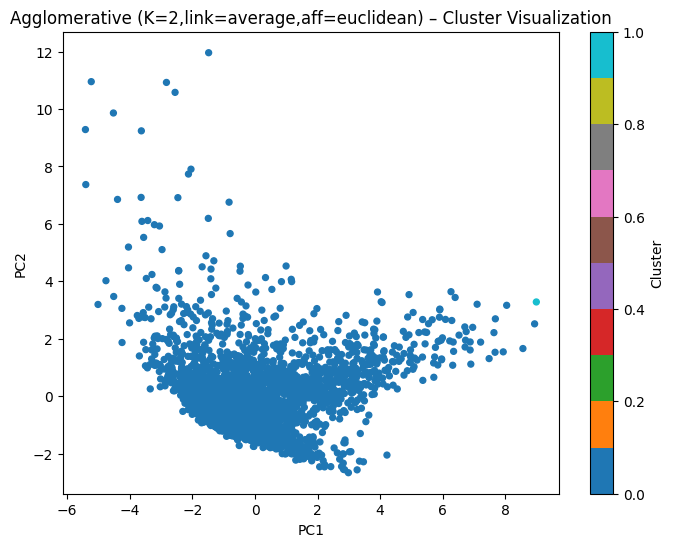

In [ ]:
labels_best_all = visualize_best_clustering_results(
    results_df_all.iloc[0], labels_store_all, X_weighted_all
)

In [ ]:
def run_umap_and_evaluate_clustering_extended(
        X_data, evaluate_func, current_results_df, current_labels_store):

    for nn in [10, 15, 20, 30]:
        for md in [0.0, 0.1, 0.5]:
            for spread in [1.0, 1.5]:
                for n_comp in [2]:
                    for lr in [1.0, 5.0]:
                        for metric in ["euclidean", "manhattan", "cosine"]:

                            reducer = umap.UMAP(
                                n_neighbors=nn,
                                min_dist=md,
                                spread=spread,
                                n_components=n_comp,
                                learning_rate=lr,
                                metric=metric,
                                random_state=42
                            )

                            X_umap = reducer.fit_transform(X_data)

                            # UMAP + KMEANS
                            for k in range(2, 10):
                                km = KMeans(n_clusters=k, random_state=42, n_init=10)
                                lab = km.fit_predict(X_umap)

                                param = f"K={k},nn={nn},md={md},spread={spread},lr={lr},met={metric}"

                                res = evaluate_func(X_umap, lab, "UMAP+KMeans", param)

                                current_results_df = pd.concat(
                                    [current_results_df, pd.DataFrame([res])],
                                    ignore_index=True
                                )

                                current_labels_store[("UMAP+KMeans", param)] = lab

                            #  UMAP + HDBSCAN
                            for mcs in [10, 20, 40, 60]:
                                hdb = hdbscan.HDBSCAN(min_cluster_size=mcs)
                                lab = hdb.fit_predict(X_umap)

                                param = f"mcs={mcs},nn={nn},md={md},spread={spread},lr={lr},met={metric}"

                                res = evaluate_func(X_umap, lab, "UMAP+HDBSCAN", param)

                                current_results_df = pd.concat(
                                    [current_results_df, pd.DataFrame([res])],
                                    ignore_index=True
                                )

                                current_labels_store[("UMAP+HDBSCAN", param)] = lab

    return current_results_df.sort_values("silhouette", ascending=False), \
           current_labels_store, X_umap


results_df_all, labels_store_all, X_umap_all = \
    run_umap_and_evaluate_clustering_extended(
        X_weighted_all, evaluate_clustering,
        results_df_all, labels_store_all
    )

results_df_all.head(15)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/

,method,param,silhouette,calinski,davies,n_clusters,noise_frac
0,Agglomerative,"K=2,link=average,aff=euclidean",0.756754,26.698682,0.167212,2,0.000000
1,Agglomerative,"K=3,link=average,aff=euclidean",0.715284,81.515364,0.329540,3,0.000000
2,Agglomerative,"K=2,link=complete,aff=euclidean",0.682544,171.430992,0.530934,2,0.000000
3,Agglomerative,"K=3,link=complete,aff=euclidean",0.668952,240.326237,0.519013,3,0.000000
4,DBSCAN,"eps=0.9,ms=5,met=manhattan",0.620337,140.623774,0.517754,6,0.988145
5,Spectral,"K=2,nn=5",0.610790,359.205731,0.696698,2,0.000000
610,UMAP+HDBSCAN,"mcs=10,nn=15,md=0.0,spread=1.0,lr=1.0,met=eucl...",0.606932,5146.278320,0.471538,62,0.250240
6,Spectral,"K=2,nn=10",0.606144,362.397970,0.719746,2,0.000000
7,Agglomerative,"K=4,link=average,aff=euclidean",0.598405,180.504912,0.552054,4,0.000000
8,Agglomerative,"K=2,link=average,aff=manhattan",0.595266,354.918103,0.773955,2,0.000000


Best model: Agglomerative K=2,link=average,aff=euclidean
method                         Agglomerative
param         K=2,link=average,aff=euclidean
silhouette                          0.756754
calinski                           26.698682
davies                              0.167212
n_clusters                                 2
noise_frac                               0.0
Name: 0, dtype: object


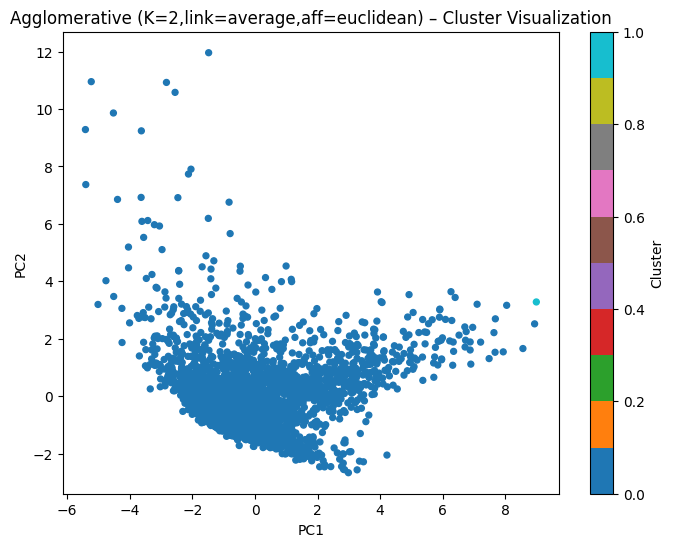

In [ ]:
labels_best_all = visualize_best_clustering_results(
    results_df_all.iloc[0], labels_store_all, X_weighted_all, X_umap_all
)

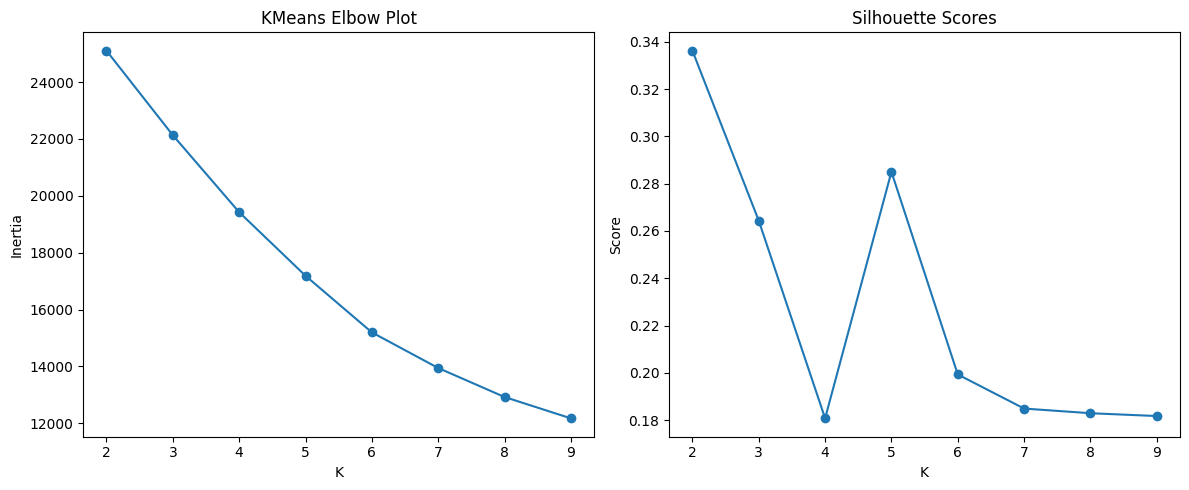

In [ ]:

# KMEANS ELBOW & SILHOUETTE


k_values = range(2, 10)
sil_scores = []
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lab = km.fit_predict(X_weighted_all)

    sil_scores.append(silhouette_score(X_weighted_all, lab))
    inertias.append(km.inertia_)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker="o")
plt.title("KMeans Elbow Plot")
plt.xlabel("K")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_values, sil_scores, marker="o")
plt.title("Silhouette Scores")
plt.xlabel("K")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


In [ ]:
#  PCA Variance Explained (for interpretability)
pca = PCA(n_components=2)
pca.fit(X_weighted_all)
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total 2D variance explained:", pca.explained_variance_ratio_.sum())


Explained variance ratio (PC1, PC2): [0.31211475 0.17102275]
Total 2D variance explained: 0.4831375025270196


In [ ]:

def summarize_clusters(df_final, labels_best, features, target_col):

    df_clusters = df_final.copy()
    df_clusters["cluster"] = labels_best

    # Remove noise cluster if exists
    # if (df_clusters["cluster"] == -1).any():
    #     df_clusters = df_clusters[df_clusters["cluster"] != -1]

    # Only use columns that exist in df
    available_cols = [c for c in features + [target_col] if c in df_clusters.columns]

    summary = (
        df_clusters.groupby("cluster")[available_cols]
        .mean()
        .round(3)
    )

    print("Cluster sizes:")
    display(df_clusters["cluster"].value_counts())

    return df_clusters, summary

df_clusters_all, summary_all = summarize_clusters(
    df_final, labels_best_all, ses_features + demo_features, target_col
)
summary_all

Cluster sizes:


,count
cluster,
0,3120
1,1


,poverty_rate,median_household_income,physical_inactivity_rate,low_access_food_rate,unemployment_rate,pct_white,pct_black,pct_hispanic,pct_asian,pct_native,obesity_rate
cluster,,,,,,,,,,,
0,0.145,55520.961,0.242,0.462,0.040,0.843,0.094,0.097,0.016,0.024,0.288
1,0.268,35369.000,0.238,0.899,0.182,0.032,0.003,0.001,0.004,0.933,0.226


In [ ]:
# ===========================
# CLUSTER FEATURE COMPARISON
# ===========================

# cluster_means = df_clusters_all.groupby("cluster")[ses_features + demo_features + [target_col]].mean()

# display(
#     cluster_means.T.sort_values(by=list(cluster_means.columns), ascending=False)
# )


# SES Only

In [ ]:
weights_ses = calculate_feature_weights(df_final, ses_features, target_col)

scaler_ses = StandardScaler()
X_ses_scaled = scaler_ses.fit_transform(df_final[ses_features])
# X_ses_weighted = X_ses_scaled * weights_ses
X_ses_weighted = X_ses_scaled
results_df_ses, labels_store_ses = run_and_evaluate_clustering_extended(
    X_ses_weighted, evaluate_clustering
)

Feature Importances:


,0
physical_inactivity_rate,0.457648
median_household_income,0.170042
low_access_food_rate,0.135839
poverty_rate,0.118602
unemployment_rate,0.117869


Weights used for clustering:


,0
physical_inactivity_rate,2.288238
median_household_income,0.850211
low_access_food_rate,0.679195
poverty_rate,0.593011
unemployment_rate,0.589344


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Best model: Agglomerative K=2,link=complete,aff=euclidean
method                          Agglomerative
param         K=2,link=complete,aff=euclidean
silhouette                           0.706588
calinski                            76.302532
davies                               0.390102
n_clusters                                  2
noise_frac                                0.0
Name: 35, dtype: object


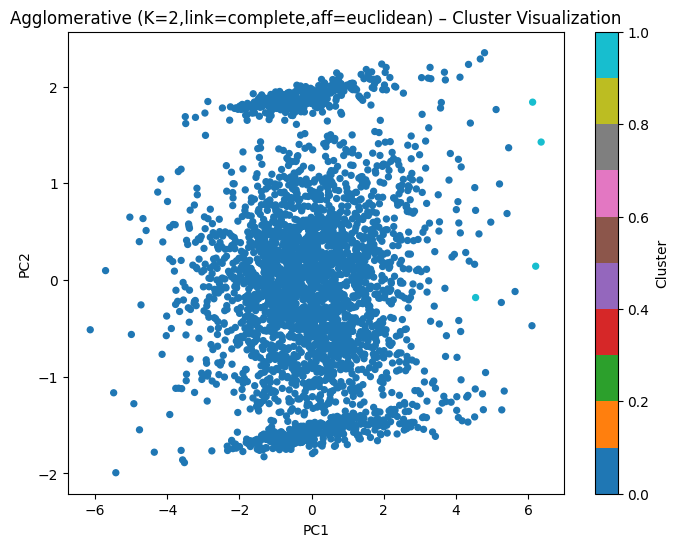

In [ ]:
labels_best_ses = visualize_best_clustering_results(
    results_df_ses.iloc[0], labels_store_ses, X_ses_weighted
)

In [ ]:

results_df_ses, labels_store_ses, X_umap_ses = \
    run_umap_and_evaluate_clustering_extended(
        X_ses_weighted, evaluate_clustering,
        results_df_ses, labels_store_ses
    )


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/

In [ ]:
results_df_ses.head(15)

,method,param,silhouette,calinski,davies,n_clusters,noise_frac
1,Agglomerative,"K=2,link=average,aff=manhattan",0.706588,76.302532,0.390102,2,0.000000
0,Agglomerative,"K=2,link=complete,aff=euclidean",0.706588,76.302532,0.390102,2,0.000000
2,Agglomerative,"K=2,link=average,aff=euclidean",0.635780,118.878652,0.559010,2,0.000000
178,UMAP+HDBSCAN,"mcs=10,nn=10,md=0.0,spread=1.0,lr=1.0,met=eucl...",0.622195,8941.083008,0.455875,90,0.307594
190,UMAP+HDBSCAN,"mcs=10,nn=10,md=0.0,spread=1.0,lr=1.0,met=manh...",0.619343,9287.808594,0.460182,87,0.328100
202,UMAP+HDBSCAN,"mcs=10,nn=10,md=0.0,spread=1.0,lr=1.0,met=cosine",0.597155,8730.690430,0.464315,90,0.247997
634,UMAP+HDBSCAN,"mcs=10,nn=15,md=0.0,spread=1.0,lr=1.0,met=cosine",0.594871,7667.873047,0.463875,84,0.269145
238,UMAP+HDBSCAN,"mcs=10,nn=10,md=0.0,spread=1.0,lr=5.0,met=cosine",0.593937,8191.441406,0.465274,87,0.257289
670,UMAP+HDBSCAN,"mcs=10,nn=15,md=0.0,spread=1.0,lr=5.0,met=cosine",0.592716,7569.054688,0.466829,75,0.281320
622,UMAP+HDBSCAN,"mcs=10,nn=15,md=0.0,spread=1.0,lr=1.0,met=manh...",0.591831,7947.675293,0.473906,75,0.323294


Best model: Agglomerative K=2,link=complete,aff=euclidean
method                          Agglomerative
param         K=2,link=complete,aff=euclidean
silhouette                           0.706588
calinski                            76.302532
davies                               0.390102
n_clusters                                  2
noise_frac                                0.0
Name: 0, dtype: object


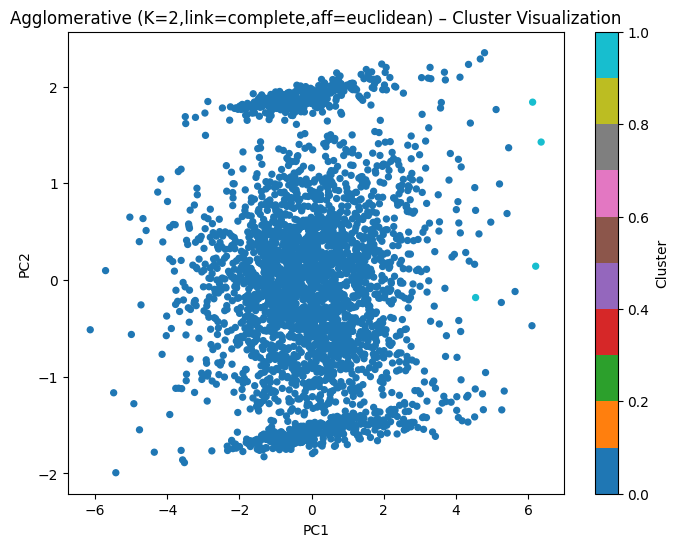

In [ ]:
labels_best_ses = visualize_best_clustering_results(
    results_df_ses.iloc[1], labels_store_ses, X_ses_weighted, X_umap_ses
)

In [ ]:
df_clusters_ses, summary_ses = summarize_clusters(
    df_final, labels_best_ses, ses_features, target_col
)

summary_ses

Cluster sizes:


,count
cluster,
0,3117
1,4


,poverty_rate,median_household_income,physical_inactivity_rate,low_access_food_rate,unemployment_rate,obesity_rate
cluster,,,,,,
0,0.145,55533.975,0.242,0.462,0.039,0.288
1,0.245,40341.500,0.255,0.623,0.179,0.315


# Demo Only

In [ ]:
weights_demo = calculate_feature_weights(df_final, demo_features, target_col)

scaler_demo = StandardScaler()
X_demo_scaled = scaler_demo.fit_transform(df_final[demo_features])
# X_demo_weighted = X_demo_scaled * weights_demo
X_demo_weighted = X_demo_scaled

results_df_demo, labels_store_demo = run_and_evaluate_clustering_extended(
    X_demo_weighted, evaluate_clustering
)
results_df_demo.head(15)

Feature Importances:


,0
pct_hispanic,0.231714
pct_asian,0.226295
pct_native,0.214783
pct_black,0.171012
pct_white,0.156196


Weights used for clustering:


,0
pct_hispanic,1.158570
pct_asian,1.131477
pct_native,1.073915
pct_black,0.855060
pct_white,0.780978


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ma

,method,param,silhouette,calinski,davies,n_clusters,noise_frac
34,Agglomerative,"K=2,link=average,aff=manhattan",0.841064,137.396915,0.189542,2,0.000000
169,HDBSCAN,"mcs=60,ms=20",0.816067,3741.694217,0.265756,2,0.495674
166,HDBSCAN,"mcs=40,ms=20",0.816067,3741.694217,0.265756,2,0.495674
163,HDBSCAN,"mcs=20,ms=20",0.816067,3741.694217,0.265756,2,0.495674
160,HDBSCAN,"mcs=10,ms=20",0.810112,3066.204567,0.292389,3,0.489587
33,Agglomerative,"K=2,link=average,aff=euclidean",0.809767,316.779121,0.321385,2,0.000000
35,Agglomerative,"K=2,link=complete,aff=euclidean",0.809767,316.779121,0.321385,2,0.000000
36,Agglomerative,"K=2,link=complete,aff=manhattan",0.798729,336.317676,0.369399,2,0.000000
136,DBSCAN,"eps=0.5,ms=5,met=euclidean",0.793592,139.204839,0.181347,2,0.060558
149,DBSCAN,"eps=0.9,ms=5,met=manhattan",0.792532,175.650013,0.236423,3,0.056713


Best model: Agglomerative K=2,link=average,aff=manhattan
method                         Agglomerative
param         K=2,link=average,aff=manhattan
silhouette                          0.841064
calinski                          137.396915
davies                              0.189542
n_clusters                                 2
noise_frac                               0.0
Name: 34, dtype: object


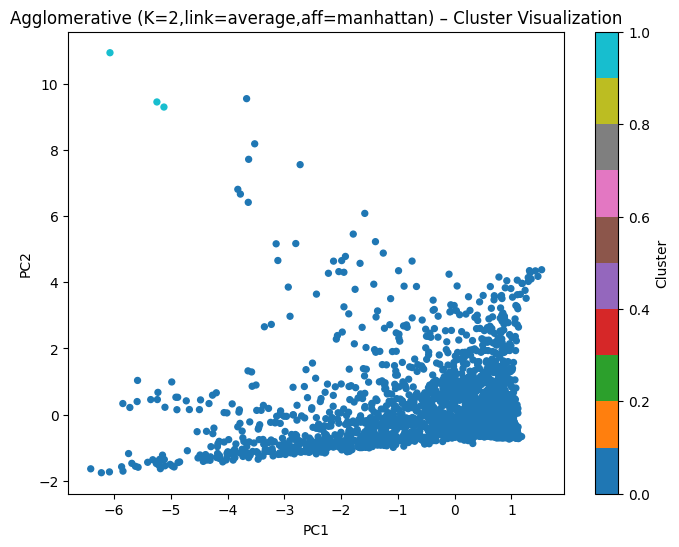

In [ ]:
labels_best_demo = visualize_best_clustering_results(
    results_df_demo.iloc[0], labels_store_demo, X_demo_weighted
)

In [ ]:
results_df_demo, labels_store_demo, X_umap_demo = \
    run_umap_and_evaluate_clustering_extended(
        X_demo_weighted, evaluate_clustering,
        results_df_demo, labels_store_demo
    )
results_df_demo.head(15)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/

,method,param,silhouette,calinski,davies,n_clusters,noise_frac
0,Agglomerative,"K=2,link=average,aff=manhattan",0.841064,137.396915,0.189542,2,0.000000
1,HDBSCAN,"mcs=60,ms=20",0.816067,3741.694217,0.265756,2,0.495674
2,HDBSCAN,"mcs=40,ms=20",0.816067,3741.694217,0.265756,2,0.495674
3,HDBSCAN,"mcs=20,ms=20",0.816067,3741.694217,0.265756,2,0.495674
4,HDBSCAN,"mcs=10,ms=20",0.810112,3066.204567,0.292389,3,0.489587
6,Agglomerative,"K=2,link=complete,aff=euclidean",0.809767,316.779121,0.321385,2,0.000000
5,Agglomerative,"K=2,link=average,aff=euclidean",0.809767,316.779121,0.321385,2,0.000000
7,Agglomerative,"K=2,link=complete,aff=manhattan",0.798729,336.317676,0.369399,2,0.000000
8,DBSCAN,"eps=0.5,ms=5,met=euclidean",0.793592,139.204839,0.181347,2,0.060558
9,DBSCAN,"eps=0.9,ms=5,met=manhattan",0.792532,175.650013,0.236423,3,0.056713


Best model: Agglomerative K=2,link=average,aff=manhattan
method                         Agglomerative
param         K=2,link=average,aff=manhattan
silhouette                          0.841064
calinski                          137.396915
davies                              0.189542
n_clusters                                 2
noise_frac                               0.0
Name: 0, dtype: object


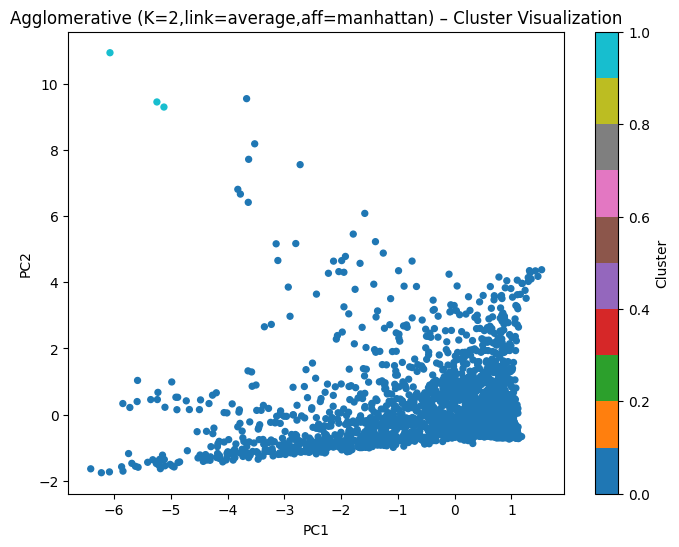

In [ ]:
labels_best_demo = visualize_best_clustering_results(
    results_df_demo.iloc[0], labels_store_demo, X_demo_weighted, X_umap_demo
)

In [ ]:
df_clusters_demo, summary_demo = summarize_clusters(
    df_final, labels_best_demo, demo_features, target_col
)

summary_demo

Cluster sizes:


,count
cluster,
0,3118
1,3


,pct_white,pct_black,pct_hispanic,pct_asian,pct_native,obesity_rate
cluster,,,,,,
0,0.843,0.094,0.097,0.015,0.024,0.288
1,0.261,0.074,0.140,0.436,0.076,0.265


# Economic

In [ ]:
#Economic
weights_eco = calculate_feature_weights(df_final, economic_features, target_col)

scaler_eco = StandardScaler()
X_eco_scaled = scaler_eco.fit_transform(df_final[economic_features])
# X_ses_weighted = X_ses_scaled * weights_ses
X_eco_weighted = X_eco_scaled

Feature Importances:


,0
median_household_income,0.339751
unemployment_rate,0.335637
poverty_rate,0.324612


Weights used for clustering:


,0
median_household_income,1.019254
unemployment_rate,1.006911
poverty_rate,0.973835


In [ ]:
results_df_eco, labels_store_eco = run_and_evaluate_clustering_extended(
    X_eco_weighted, evaluate_clustering
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

In [ ]:
results_df_eco.head(15)

,method,param,silhouette,calinski,davies,n_clusters,noise_frac
35,Agglomerative,"K=2,link=complete,aff=euclidean",0.785599,128.665556,0.289619,2,0.000000
33,Agglomerative,"K=2,link=average,aff=euclidean",0.680301,337.816678,0.593601,2,0.000000
140,DBSCAN,"eps=0.7,ms=3,met=euclidean",0.678195,44.154536,0.283311,2,0.005447
146,DBSCAN,"eps=0.9,ms=3,met=euclidean",0.675186,43.420670,0.284818,2,0.003204
34,Agglomerative,"K=2,link=average,aff=manhattan",0.671609,351.885215,0.653667,2,0.000000
147,DBSCAN,"eps=0.9,ms=3,met=manhattan",0.658969,56.674365,0.275875,2,0.009933
38,Agglomerative,"K=3,link=average,aff=euclidean",0.645616,175.719367,0.497262,3,0.000000
39,Agglomerative,"K=3,link=average,aff=manhattan",0.637272,197.638860,0.602958,3,0.000000
43,Agglomerative,"K=4,link=average,aff=euclidean",0.628556,127.971694,0.487511,4,0.000000
44,Agglomerative,"K=4,link=average,aff=manhattan",0.597329,141.490736,0.543690,4,0.000000


Best model: Agglomerative K=2,link=complete,aff=euclidean
method                          Agglomerative
param         K=2,link=complete,aff=euclidean
silhouette                           0.785599
calinski                           128.665556
davies                               0.289619
n_clusters                                  2
noise_frac                                0.0
Name: 35, dtype: object


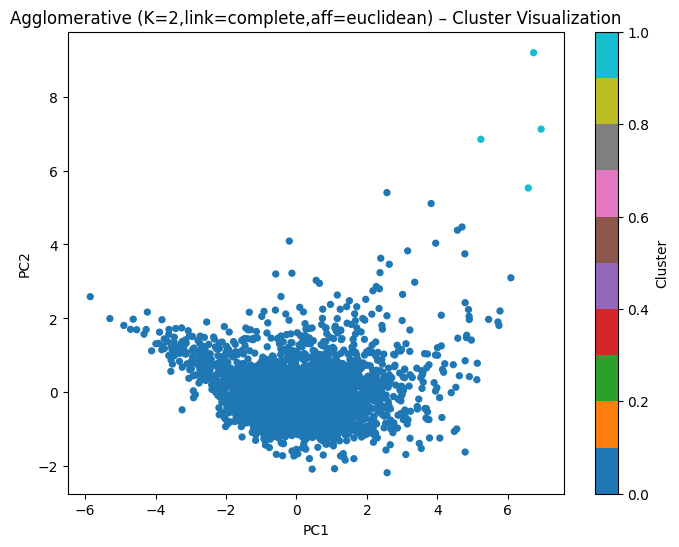

In [ ]:
labels_best_eco = visualize_best_clustering_results(
    results_df_eco.iloc[0], labels_store_eco, X_eco_weighted
)

# Health

In [ ]:
#Health
weights_heal = calculate_feature_weights(df_final, health_features, target_col)

scaler_heal = StandardScaler()
X_heal_scaled = scaler_heal.fit_transform(df_final[health_features])
# X_demo_weighted = X_demo_scaled * weights_demo
X_heal_weighted = X_heal_scaled

Feature Importances:


,0
physical_inactivity_rate,0.690256
low_access_food_rate,0.309744


Weights used for clustering:


,0
physical_inactivity_rate,1.380512
low_access_food_rate,0.619488


In [ ]:
results_df_heal, labels_store_heal = run_and_evaluate_clustering_extended(
    X_heal_weighted, evaluate_clustering
)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ma

In [ ]:
results_df_ses.head(15)

,method,param,silhouette,calinski,davies,n_clusters,noise_frac
1,Agglomerative,"K=2,link=average,aff=manhattan",0.706588,76.302532,0.390102,2,0.000000
0,Agglomerative,"K=2,link=complete,aff=euclidean",0.706588,76.302532,0.390102,2,0.000000
2,Agglomerative,"K=2,link=average,aff=euclidean",0.635780,118.878652,0.559010,2,0.000000
178,UMAP+HDBSCAN,"mcs=10,nn=10,md=0.0,spread=1.0,lr=1.0,met=eucl...",0.622195,8941.083008,0.455875,90,0.307594
190,UMAP+HDBSCAN,"mcs=10,nn=10,md=0.0,spread=1.0,lr=1.0,met=manh...",0.619343,9287.808594,0.460182,87,0.328100
202,UMAP+HDBSCAN,"mcs=10,nn=10,md=0.0,spread=1.0,lr=1.0,met=cosine",0.597155,8730.690430,0.464315,90,0.247997
634,UMAP+HDBSCAN,"mcs=10,nn=15,md=0.0,spread=1.0,lr=1.0,met=cosine",0.594871,7667.873047,0.463875,84,0.269145
238,UMAP+HDBSCAN,"mcs=10,nn=10,md=0.0,spread=1.0,lr=5.0,met=cosine",0.593937,8191.441406,0.465274,87,0.257289
670,UMAP+HDBSCAN,"mcs=10,nn=15,md=0.0,spread=1.0,lr=5.0,met=cosine",0.592716,7569.054688,0.466829,75,0.281320
622,UMAP+HDBSCAN,"mcs=10,nn=15,md=0.0,spread=1.0,lr=1.0,met=manh...",0.591831,7947.675293,0.473906,75,0.323294


Best model: DBSCAN eps=0.5,ms=5,met=manhattan
method                            DBSCAN
param         eps=0.5,ms=5,met=manhattan
silhouette                      0.442045
calinski                         21.7123
davies                          0.436498
n_clusters                             2
noise_frac                      0.001922
Name: 137, dtype: object


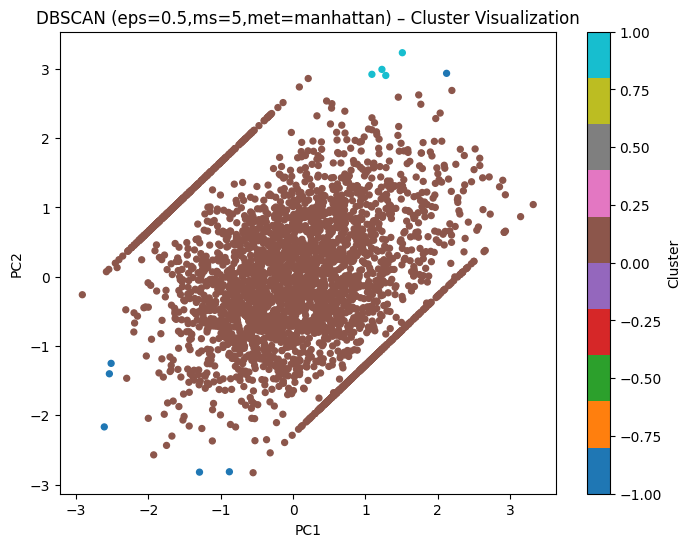

In [ ]:
labels_best_heal = visualize_best_clustering_results(
    results_df_heal.iloc[0], labels_store_heal, X_heal_weighted
)

# New Section

In [ ]:
best_all = results_df_all.iloc[0]
best_all


,0
method,Agglomerative
param,"K=2,link=average,aff=euclidean"
silhouette,0.756754
calinski,26.698682
davies,0.167212
n_clusters,2
noise_frac,0.0


Best model: Agglomerative K=2,link=average,aff=euclidean
method                         Agglomerative
param         K=2,link=average,aff=euclidean
silhouette                          0.756754
calinski                           26.698682
davies                              0.167212
n_clusters                                 2
noise_frac                               0.0
Name: 0, dtype: object


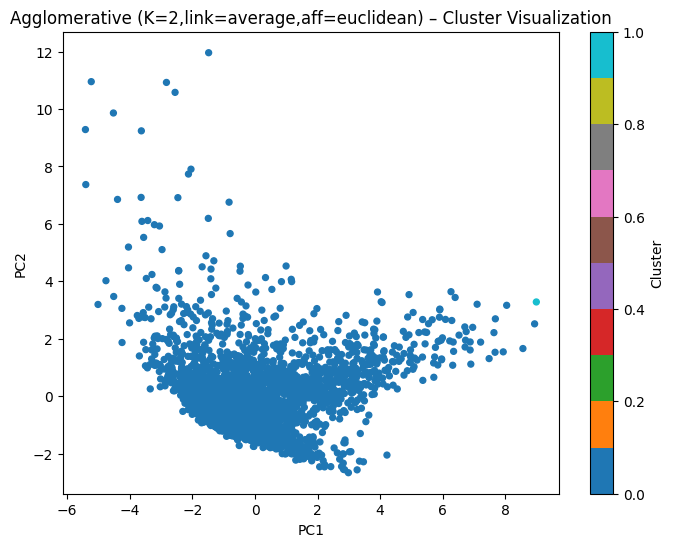

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
labels_best_all = labels_store_all[(best_all["method"], best_all["param"])]

visualize_best_clustering_results(
    best_all,
    labels_store_all,
    X_weighted_all,
    X_umap_all
)

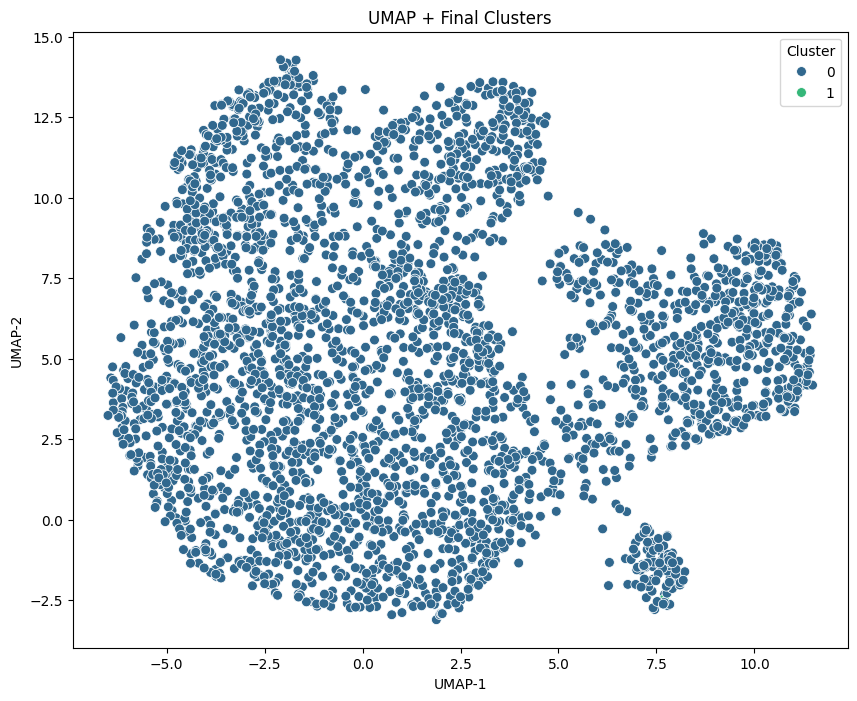

In [ ]:
# ===========================
# FINAL UMAP + CLUSTER PLOT
# ===========================

plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=X_umap_all[:, 0],
    y=X_umap_all[:, 1],
    hue=labels_best_all,
    palette="viridis",
    s=50
)

plt.title("UMAP + Final Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.show()


In [ ]:
df_clusters_all, summary_all = summarize_clusters(
    df_final,
    labels_best_all,
    ses_features + demo_features, # Combine ses_features and demo_features
    target_col
)

summary_all

Cluster sizes:


,count
cluster,
0,3120
1,1


,poverty_rate,median_household_income,physical_inactivity_rate,low_access_food_rate,unemployment_rate,pct_white,pct_black,pct_hispanic,pct_asian,pct_native,obesity_rate
cluster,,,,,,,,,,,
0,0.145,55520.961,0.242,0.462,0.040,0.843,0.094,0.097,0.016,0.024,0.288
1,0.268,35369.000,0.238,0.899,0.182,0.032,0.003,0.001,0.004,0.933,0.226


In [ ]:
# ===========================
# CLUSTER FEATURE COMPARISON
# ===========================

# cluster_means = df_clusters_all.groupby("cluster")[ses_features + demo_features + [target_col]].mean()

# display(
#     cluster_means.T.sort_values(by=list(cluster_means.columns), ascending=False)
# )


/tmp/ipython-input-21279056.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


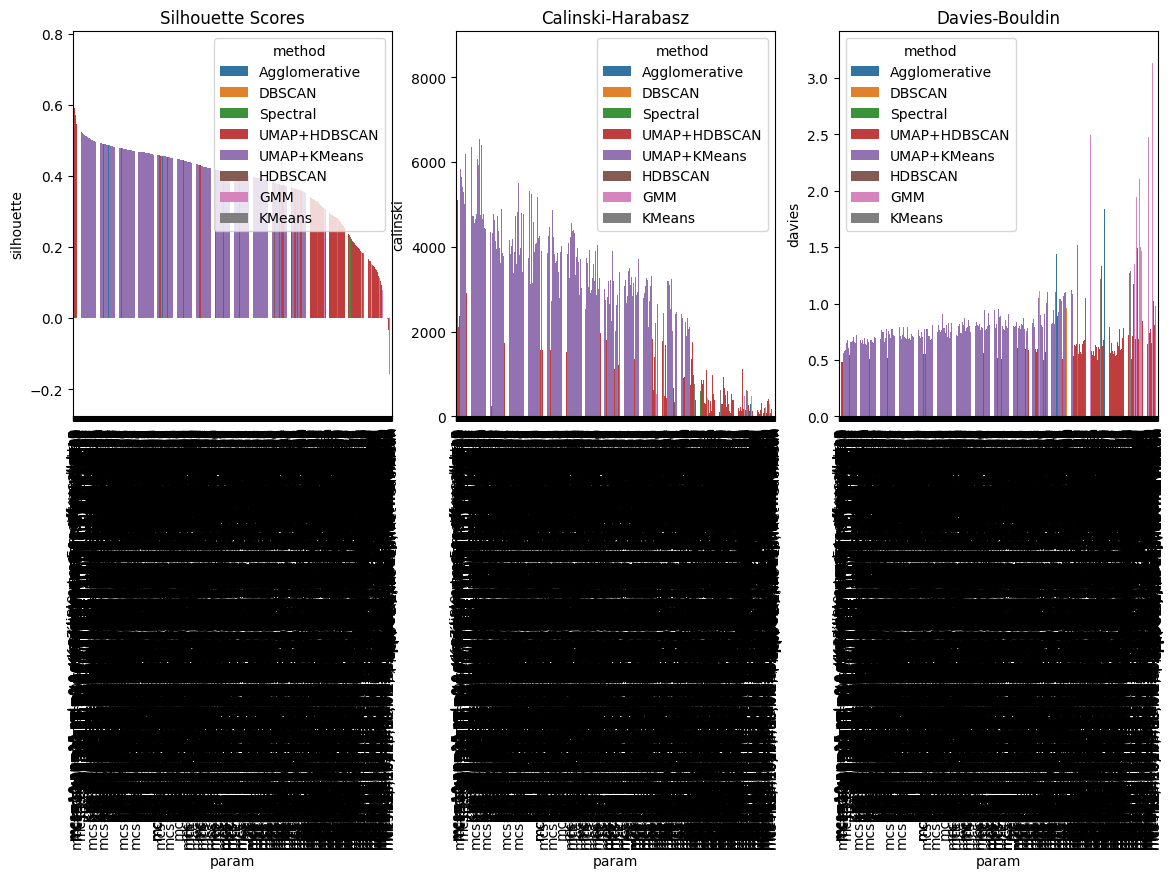

In [ ]:
# === Visualization of Clustering Metrics ===
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
sns.barplot(data=results_df_all, x="param", y="silhouette", hue="method")
plt.xticks(rotation=90)
plt.title("Silhouette Scores")

plt.subplot(1,3,2)
sns.barplot(data=results_df_all, x="param", y="calinski", hue="method")
plt.xticks(rotation=90)
plt.title("Calinski-Harabasz")

plt.subplot(1,3,3)
sns.barplot(data=results_df_all, x="param", y="davies", hue="method")
plt.xticks(rotation=90)
plt.title("Davies-Bouldin")

plt.tight_layout()
plt.show()


In [ ]:
print("=== Cluster Count Summary ===")
print(results_df_all[["method","param","n_clusters","noise_frac","silhouette"]].head(20))


=== Cluster Count Summary ===
            method                                              param  \
0           DBSCAN                         eps=0.7,ms=3,met=manhattan   
1           DBSCAN                        eps=0.5,ms=10,met=euclidean   
1333  UMAP+HDBSCAN  mcs=60,nn=20,md=0.5,spread=1.0,lr=1.0,met=eucl...   
1562   UMAP+KMeans      K=2,nn=30,md=0.0,spread=1.5,lr=1.0,met=cosine   
1573  UMAP+HDBSCAN   mcs=60,nn=30,md=0.0,spread=1.5,lr=1.0,met=cosine   
1572  UMAP+HDBSCAN   mcs=40,nn=30,md=0.0,spread=1.5,lr=1.0,met=cosine   
1130   UMAP+KMeans      K=2,nn=20,md=0.0,spread=1.5,lr=1.0,met=cosine   
1141  UMAP+HDBSCAN   mcs=60,nn=20,md=0.0,spread=1.5,lr=1.0,met=cosine   
1069  UMAP+HDBSCAN   mcs=60,nn=20,md=0.0,spread=1.0,lr=1.0,met=cosine   
1058   UMAP+KMeans      K=2,nn=20,md=0.0,spread=1.0,lr=1.0,met=cosine   
1777  UMAP+HDBSCAN  mcs=60,nn=30,md=0.5,spread=1.0,lr=1.0,met=manh...   
1490   UMAP+KMeans      K=2,nn=30,md=0.0,spread=1.0,lr=1.0,met=cosine   
1500  UMAP+HDBSCAN   

In [ ]:
results_df_all.sort_values("silhouette", ascending=False)


,method,param,silhouette,calinski,davies,n_clusters,noise_frac
0,DBSCAN,"eps=0.7,ms=3,met=manhattan",0.733118,318.995532,0.308745,10,0.988786
1,DBSCAN,"eps=0.5,ms=10,met=euclidean",0.701590,234.953658,0.417228,3,0.983979
1333,UMAP+HDBSCAN,"mcs=60,nn=20,md=0.5,spread=1.0,lr=1.0,met=eucl...",0.696619,1518.303833,0.415289,2,0.877603
1562,UMAP+KMeans,"K=2,nn=30,md=0.0,spread=1.5,lr=1.0,met=cosine",0.683271,11636.257812,0.470760,2,0.000000
1573,UMAP+HDBSCAN,"mcs=60,nn=30,md=0.0,spread=1.5,lr=1.0,met=cosine",0.683271,11636.257812,0.470760,2,0.000000
...,...,...,...,...,...,...,...
165,DBSCAN,"eps=0.9,ms=10,met=euclidean",NaN,NaN,NaN,1,0.387376
166,DBSCAN,"eps=0.9,ms=10,met=manhattan",NaN,NaN,NaN,0,1.000000
167,HDBSCAN,"mcs=40,ms=20",NaN,NaN,NaN,0,1.000000
168,HDBSCAN,"mcs=60,ms=10",NaN,NaN,NaN,0,1.000000


# Validation

In [ ]:
# === VALIDATION 1: MAP KNOWN CDC REGIONS ===

# Defined regions based on CDC / USDA classifications
south_states = ["AL","AR","GA","KY","LA","MS","NC","SC","TN","TX","OK","WV"]
midwest_states = ["IL","IN","IA","KS","MI","MN","MO","NE","ND","OH","SD","WI"]
west_states = ["AK","AZ","CA","CO","HI","ID","MT","NV","NM","OR","UT","WA","WY"]
northeast_states = ["CT","DE","MA","MD","ME","NH","NJ","NY","PA","RI","VT","VA"]

def assign_region(row):
    s = row['state_abbr']
    if s in south_states: return "South"
    if s in midwest_states: return "Midwest"
    if s in west_states: return "West"
    if s in northeast_states: return "Northeast"
    return "Other"

# Add region column if not present
if "state_abbr" not in df_clusters_all.columns:
    # Your dataset likely has state_code numeric
    df_clusters_all["state_abbr"] = df_clusters_all["state_code"].astype(int).map({
        1:"AL",2:"AK",4:"AZ",5:"AR",6:"CA",8:"CO",9:"CT",10:"DE",11:"DC",12:"FL",
        13:"GA",15:"HI",16:"ID",17:"IL",18:"IN",19:"IA",20:"KS",21:"KY",22:"LA",
        23:"ME",24:"MD",25:"MA",26:"MI",27:"MN",28:"MS",29:"MO",30:"MT",31:"NE",
        32:"NV",33:"NH",34:"NJ",35:"NM",36:"NY",37:"NC",38:"ND",39:"OH",40:"OK",
        41:"OR",42:"PA",44:"RI",45:"SC",46:"SD",47:"TN",48:"TX",49:"UT",50:"VT",
        51:"VA",53:"WA",54:"WV",55:"WI",56:"WY"
    })

df_clusters_all["region"] = df_clusters_all.apply(assign_region, axis=1)

# Compare cluster obesity vs region obesity
region_check = df_clusters_all.groupby("region")["obesity_rate"].mean().sort_values()
cluster_check = df_clusters_all.groupby("cluster")["obesity_rate"].mean().sort_values()

print("=== Mean Obesity Rate by Region (CDC expectation) ===")
print(region_check)

print("\n=== Mean Obesity Rate by Your Clusters ===")
print(cluster_check)


=== Mean Obesity Rate by Region (CDC expectation) ===
region
West         0.270865
South        0.283881
Northeast    0.292598
Midwest      0.296607
Other        0.302313
Name: obesity_rate, dtype: float64

=== Mean Obesity Rate by Your Clusters ===
cluster
0    0.270526
1    0.307565
Name: obesity_rate, dtype: float64


In [ ]:
# === VALIDATION 2: CORRELATION CHECKS ===

ses_cols = ["poverty_rate","median_household_income","physical_inactivity_rate",
            "low_access_food_rate","unemployment_rate"]

corr = df_final[ses_cols + ["obesity_rate"]].corr()["obesity_rate"].sort_values()

print("=== SES → Obesity Correlation (Should match CDC trends) ===")
print(corr)


=== SES → Obesity Correlation (Should match CDC trends) ===
median_household_income    -0.047845
low_access_food_rate       -0.044566
poverty_rate                0.028696
unemployment_rate           0.093470
physical_inactivity_rate    0.559164
obesity_rate                1.000000
Name: obesity_rate, dtype: float64


In [ ]:
# === VALIDATION 3: ARE HIGH-OBESITY CLUSTERS CLEARLY SEPARATED? ===

cluster_stats = df_clusters_all.groupby("cluster")["obesity_rate"].agg(
    ['mean','median','std','min','max','count']
).sort_values("mean")

print("=== Cluster-wise Obesity Validation ===")
print(cluster_stats)

# Check effect size (high – low)
low = cluster_stats.iloc[0]["mean"]
high = cluster_stats.iloc[-1]["mean"]
print("\nObesity gap between lowest and highest cluster:", round(high - low, 3))


=== Cluster-wise Obesity Validation ===
             mean    median       std       min       max  count
cluster                                                         
0        0.270526  0.264003  0.042664  0.138000  0.437003   1673
1        0.307565  0.309002  0.047218  0.203022  0.453001   1448

Obesity gap between lowest and highest cluster: 0.037


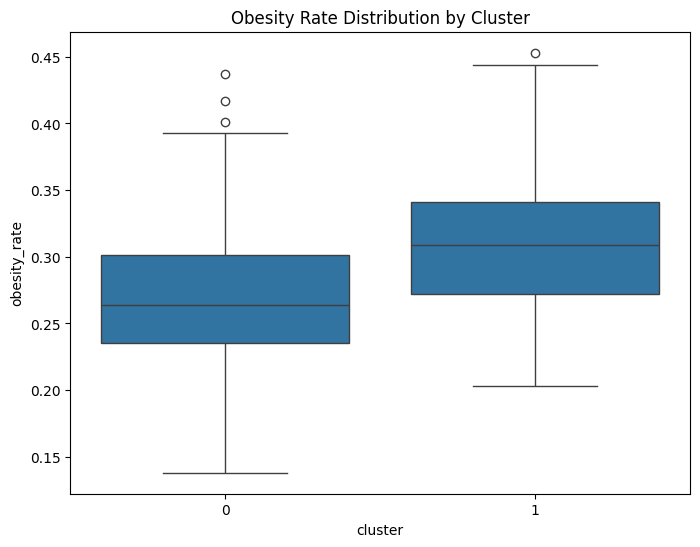

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_clusters_all, x="cluster", y="obesity_rate")
plt.title("Obesity Rate Distribution by Cluster")
plt.show()


In [ ]:
# === VALIDATION 4: Baseline vs Model Comparison ===

# Naive baseline = mean obesity
baseline_pred = df_final[target_col].mean()
baseline_rmse = np.sqrt(np.mean((df_final[target_col]-baseline_pred)**2))

print("Baseline RMSE:", baseline_rmse)

# If you have predicted values:
# model_rmse = ...
# print("Model RMSE:", model_rmse)

# Then see if model is better:
# print("Improvement:", baseline_rmse - model_rmse)


Baseline RMSE: 0.04847686103722937


# Export to Dashboard

In [ ]:
# ================================
# EXPORT FILES FOR DASHBOARD
# ================================



# Output directory
out = "/content/drive/MyDrive/obesity-risk-analytics/dashboard_data_final/"
os.makedirs(out, exist_ok=True)

print("Saving dashboard datasets to:", out)

# --------------------------------
# 1. All-features clusters
# --------------------------------
df_clusters_all.to_csv(out + "df_clusters_all.csv", index=False)
summary_all.to_csv(out + "summary_all.csv")

# Clustering model results
results_df_all.to_csv(out + "results_df_all.csv", index=False)

# UMAP embeddings
pd.DataFrame(X_umap_all, columns=["UMAP1", "UMAP2"]).to_csv(
    out + "umap_embeddings.csv", index=False
)

# Feature weights (RF importances)
pd.Series(weights_all, index=all_features).to_csv(
    out + "feature_weights_all.csv"
)

# --------------------------------
# 2. SES-only clusters
# --------------------------------
df_clusters_ses.to_csv(out + "df_clusters_ses.csv", index=False)
summary_ses.to_csv(out + "summary_ses.csv")

# --------------------------------
# 3. Demo-only clusters
# --------------------------------
df_clusters_demo.to_csv(out + "df_clusters_demo.csv", index=False)
summary_demo.to_csv(out + "summary_demo.csv")

# --------------------------------
# 4. GeoJSON (County FIPS shapes)
# --------------------------------
# with open(out + "counties_fips.geojson", "w") as f:
#     json.dump(counties_geojson, f)

print("✅ All dashboard files exported successfully!")


Saving dashboard datasets to: /content/drive/MyDrive/obesity-risk-analytics/dashboard_data_final/


NameError: name 'df_clusters_ses' is not defined